# 1. Extract information from ifc file-according to scan date

In [4]:
# extract information from ifc file
# file_path = 'New_rotated only.ifc'
# output_file = 'IFC_info_extraction.txt'


import ifcopenshell
import ifcopenshell.geom
import os

# Load the IFC model
file_path = 'New_rotated only.ifc'
ifc_file = ifcopenshell.open(file_path)

# Define the element types we are interested in
element_types = ['IfcSlab', 'IfcColumn', 'IfcWall', 'IfcBeam']

# Function to extract schedule data from the property set
def extract_schedule_data(element):
    # Iterate over the property sets of the element
    for rel_defines in element.IsDefinedBy:
        if rel_defines.is_a('IFCRELDEFINESBYPROPERTIES'):
            property_set = rel_defines.RelatingPropertyDefinition
            # Check if the property set is '10 Schedule Data'
            if property_set.is_a('IFCPROPERTYSET') and property_set.Name == '10 Schedule Data':
                schedule_data = {}
                for prop in property_set.HasProperties:
                    if prop.Name == 'Task ID':
                        schedule_data['Task ID'] = prop.NominalValue.wrappedValue
                    elif prop.Name == 'Task Name':
                        schedule_data['Task Name'] = prop.NominalValue.wrappedValue
                    elif prop.Name == 'Scheduled finish date':
                        schedule_data['Scheduled finish date'] = prop.NominalValue.wrappedValue
                    elif prop.Name == 'Scheduled start date':
                        schedule_data['Scheduled start date'] = prop.NominalValue.wrappedValue
                return schedule_data
    return None

# Function to extract bounding box data
def extract_bounding_box(element):
    try:
        # Initialize settings for geometry extraction
        settings = ifcopenshell.geom.settings()
        settings.set(settings.USE_WORLD_COORDS, True)
        
        # Create geometry for the element
        shape = ifcopenshell.geom.create_shape(settings, element)
        verts = shape.geometry.verts

        # Compute the bounding box by finding the min and max coordinates
        x_coords = verts[::3]  # All X coordinates
        y_coords = verts[1::3]  # All Y coordinates
        z_coords = verts[2::3]  # All Z coordinates

        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)
        min_z, max_z = min(z_coords), max(z_coords)

        return (min_x, min_y, min_z, max_x, max_y, max_z)
    except Exception as e:
        print(f"Error extracting bounding box for element {element.GlobalId}: {e}")
        return None

# Open the output file with UTF-8 encoding
output_file = 'IFC_info_extraction.txt'
with open(output_file, 'w', encoding='utf-8') as f:
    # Write header
    f.write("Task ID\tGUID\tTask Name\tBounding Box (min_x, min_y, min_z, max_x, max_y, max_z)\tScheduled Start Date\tScheduled Finish Date\n")

    # Iterate through each element type and extract data
    for element_type in element_types:
        elements = ifc_file.by_type(element_type)
        for element in elements:
            guid = element.GlobalId
            schedule_data = extract_schedule_data(element)
            if schedule_data:
                bounding_box = extract_bounding_box(element)
                bounding_box_str = str(bounding_box) if bounding_box else "No bounding box data"
                
                # Write the extracted data into the file
                f.write(f"{schedule_data.get('Task ID', 'N/A')}\t{guid}\t{schedule_data.get('Task Name', 'N/A')}\t"
                        f"{bounding_box_str}\t{schedule_data.get('Scheduled start date', 'N/A')}\t"
                        f"{schedule_data.get('Scheduled finish date', 'N/A')}\n")

print(f"Data extraction completed. Output written to {output_file}.")



Error extracting bounding box for element 0_xlk8san9fBkpCxjG_usV: min() arg is an empty sequence
Error extracting bounding box for element 2CMt89CjzEwB4Z9yexVAio: min() arg is an empty sequence
Error extracting bounding box for element 0hRQcJT6j1ZPNfpD83mgsF: min() arg is an empty sequence
Error extracting bounding box for element 3ZmZrDjZjFvB1$DF2hNhnZ: min() arg is an empty sequence
Data extraction completed. Output written to IFC_info_extraction.txt.


In [2]:
import os

# Function to write an OBJ file for a wireframe bounding box (lines)
def write_obj_wireframe(filename, all_vertices, all_edges):
    with open(filename, 'w') as obj_file:
        obj_file.write("# Bounding Box OBJ File\n")
        obj_file.write("g BoundingBoxes\n")

        # Write vertices
        for vertex in all_vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

        # Write edges
        for edge in all_edges:
            obj_file.write(f"l {edge[0] + 1} {edge[1] + 1}\n")  # OBJ is 1-based index

# Function to parse bounding box from the text file
def parse_bounding_boxes(file_path):
    all_vertices = []
    all_edges = []
    vertex_offset = 0

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        
        # Find the index of bounding box column
        header = lines[0].strip().split("\t")
        bbox_index = header.index("Bounding Box (min_x, min_y, min_z, max_x, max_y, max_z)")
        
        # Process each row after the header
        for line in lines[1:]:
            parts = line.strip().split("\t")
            if len(parts) <= bbox_index:
                continue  # Skip invalid rows
            
            # Extract bounding box coordinates
            bbox_values = parts[bbox_index].strip("()").split(", ")
            if len(bbox_values) != 6:
                continue  # Skip malformed data
            
            min_x, min_y, min_z, max_x, max_y, max_z = map(float, bbox_values)
            
            # Generate vertices and edges for this bounding box
            vertices, edges = generate_bounding_box(min_x, min_y, min_z, max_x, max_y, max_z, vertex_offset)
            
            # Update global lists
            all_vertices.extend(vertices)
            all_edges.extend(edges)
            vertex_offset += len(vertices)  # Offset for next box

    return all_vertices, all_edges

# Function to generate vertices and edges for a bounding box
def generate_bounding_box(min_x, min_y, min_z, max_x, max_y, max_z, offset=0):
    # Define the 8 vertices of the bounding box
    vertices = [
        [min_x, min_y, min_z],
        [min_x, min_y, max_z],
        [min_x, max_y, min_z],
        [min_x, max_y, max_z],
        [max_x, min_y, min_z],
        [max_x, min_y, max_z],
        [max_x, max_y, min_z],
        [max_x, max_y, max_z],
    ]

    # Define the 12 edges that connect the vertices
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  # Bottom face
        [4, 5], [5, 7], [7, 6], [6, 4],  # Top face
        [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
    ]

    # Adjust edges with offset
    edges = [[e[0] + offset, e[1] + offset] for e in edges]

    return vertices, edges

# Main execution
input_txt_file = "IFC_info_extraction.txt"  # Change to your actual file path
output_obj_file = "BoundingBox_OBJ_Files/bounding_boxes_20250130.obj"

# Parse bounding boxes and generate OBJ file
vertices, edges = parse_bounding_boxes(input_txt_file)
write_obj_wireframe(output_obj_file, vertices, edges)

print(f"OBJ file saved as '{output_obj_file}'")


OBJ file saved as 'BoundingBox_OBJ_Files/bounding_boxes_20250130.obj'


In [19]:
# extract the IFC boundary & GUID according to scan date intervals

import os
import re
from datetime import datetime

# Define scan dates
scan_dates = [
    datetime.strptime(date, '%Y-%m-%d') for date in [
        '2024-05-02', '2024-05-27', '2024-06-28', '2024-07-11', '2024-07-18',
        '2024-08-06', '2024-08-20', '2024-09-07', '2024-10-01', '2024-11-06'
    ]
]

# ============== Step 1: Parse TXT Data and Categorize ============== #

# Function to parse extracted IFC data from a TXT file
def parse_txt_file(file_path):
    elements = []

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        header = lines[0].strip()  # 存下原始表头
        columns = header.split("\t")

        # 定位列索引
        bbox_index = columns.index("Bounding Box (min_x, min_y, min_z, max_x, max_y, max_z)")
        finish_date_index = columns.index("Scheduled Finish Date")
        start_date_index = columns.index("Scheduled Start Date")
        task_id_index = 0
        guid_index = 1
        name_index = 2

        for line in lines[1:]:
            parts = line.strip().split("\t")
            if len(parts) <= max(bbox_index, finish_date_index):
                continue

            try:
                finish_date = datetime.strptime(parts[finish_date_index], '%d-%m-%Y')
                bbox_values = re.findall(r"[-+]?\d*\.\d+|\d+", parts[bbox_index])
                bbox_values = list(map(float, bbox_values))
                if len(bbox_values) != 6:
                    continue

                # 构造无括号的输出行（tab 分隔）
                line_cleaned = "\t".join([
                    parts[task_id_index],
                    parts[guid_index],
                    parts[name_index],
                    *["{:.3f}".format(val) for val in bbox_values],  # 统一精度（可改）
                    parts[start_date_index],
                    parts[finish_date_index]
                ])

                elements.append({
                    "finish_date": finish_date,
                    "bounding_box": tuple(bbox_values),
                    "line": line_cleaned
                })

            except ValueError:
                continue

    return elements, header


# Function to categorize elements based on scan dates
def categorize_elements(elements, scan_dates):
    scan_dates.sort()
    categorized_elements = {f"before_{scan_dates[0].strftime('%Y-%m-%d')}": []}

    # Create interval buckets: each one is for (scan_dates[i - 1], scan_dates[i]]
    for i in range(1, len(scan_dates)):
        key = f"between_{scan_dates[i - 1].strftime('%Y-%m-%d')}_and_{scan_dates[i].strftime('%Y-%m-%d')}"
        categorized_elements[key] = []

    categorized_elements[f"after_{scan_dates[-1].strftime('%Y-%m-%d')}"] = []

    for element in elements:
        date = element["finish_date"]

        if date <= scan_dates[0]:
            categorized_elements[f"before_{scan_dates[0].strftime('%Y-%m-%d')}"].append(element["line"])
            continue

        categorized = False
        for i in range(1, len(scan_dates)):
            if scan_dates[i - 1] < date <= scan_dates[i]:  # ✅ changed range logic
                key = f"between_{scan_dates[i - 1].strftime('%Y-%m-%d')}_and_{scan_dates[i].strftime('%Y-%m-%d')}"
                categorized_elements[key].append(element["line"])
                categorized = True
                break

        if not categorized:
            categorized_elements[f"after_{scan_dates[-1].strftime('%Y-%m-%d')}"].append(element["line"])

    return categorized_elements


# Function to write categorized elements into separate TXT files (no header)
def write_categorized_files(categorized_elements, output_folder, original_file_name, header=None):
    os.makedirs(output_folder, exist_ok=True)

    for category, lines in categorized_elements.items():
        output_file = os.path.join(output_folder, f"{original_file_name}_{category}.txt")
        with open(output_file, 'w', encoding='utf-8') as file:
            if lines:
                file.write("\n".join(lines))
        print(f"✅ Saved: {output_file}")



# ============== Run the Script for a Single TXT File ============== #

# Define the input file path
input_txt_file = "IFC_info_extraction.txt"  # Change this to your actual file name
output_folder = "categorized_IFC_data/new"

# Ensure the input file exists
if not os.path.exists(input_txt_file):
    print(f"Error: Input file '{input_txt_file}' not found.")
else:
    # Process the single file
    print(f"Processing {input_txt_file}...")
    elements, header = parse_txt_file(input_txt_file)
    categorized_elements = categorize_elements(elements, scan_dates)
    write_categorized_files(categorized_elements, output_folder, os.path.splitext(os.path.basename(input_txt_file))[0], header)

    print("Categorization completed. Files saved in 'categorized_IFC_data'.")




Processing IFC_info_extraction.txt...
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_before_2024-05-02.txt
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-05-02_and_2024-05-27.txt
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-05-27_and_2024-06-28.txt
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-06-28_and_2024-07-11.txt
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-07-11_and_2024-07-18.txt
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-07-18_and_2024-08-06.txt
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-08-06_and_2024-08-20.txt
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-08-20_and_2024-09-07.txt
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-09-07_and_2024-10-01.txt
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-10-01_and_2024-11-06.txt
✅ Saved: categorized_IFC_data/new\IFC_info_extraction_afte

In [3]:
import os
import re

# Function to format and re-save a single TXT file
def reformat_txt_file(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        header = lines[0].strip().split("\t")  # Extract column names
        data_lines = lines[1:]  # Skip header for processing

    # Get indexes of required columns
    task_id_index = header.index("Task ID")
    guid_index = header.index("GUID")
    task_name_index = header.index("Task Name")
    bbox_index = header.index("Bounding Box (min_x, min_y, min_z, max_x, max_y, max_z)")
    start_date_index = header.index("Scheduled Start Date")
    finish_date_index = header.index("Scheduled Finish Date")

    formatted_lines = []

    for line in data_lines:
        parts = line.strip().split("\t")

        # Ensure the line has enough parts
        if len(parts) <= max(task_id_index, guid_index, task_name_index, bbox_index, start_date_index, finish_date_index):
            continue  # Skip malformed lines

        # Extract bounding box values from parentheses
        bbox_values = re.findall(r"[-+]?\d*\.\d+|\d+", parts[bbox_index])
        if len(bbox_values) != 6:
            continue  # Skip invalid bounding boxes

        min_x, min_y, min_z, max_x, max_y, max_z = map(lambda x: f"{float(x):.3f}", bbox_values)

        # Extract other values
        task_id = parts[task_id_index]
        guid = parts[guid_index]
        task_name = parts[task_name_index]
        start_date = parts[start_date_index]
        finish_date = parts[finish_date_index]

        # Format the line with proper spacing and alignment
        formatted_line = f"{task_id:<15}\t{guid:<25}\t{task_name:<25}\t{min_x:<15}\t{min_y:<15}\t{min_z:<15}\t{max_x:<15}\t{max_y:<15}\t{max_z:<15}\t{'None':<20}\t{start_date:<15}\t{finish_date:<15}"
        formatted_lines.append(formatted_line)

    # Save the reformatted data **without a headline**
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write("\n".join(formatted_lines))

    print(f"✅ Reformatted file saved: {output_file}")

# Function to process all TXT files in a folder
def process_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

    for file_name in os.listdir(input_folder):
        if file_name.endswith(".txt"):
            input_file_path = os.path.join(input_folder, file_name)
            output_file_path = os.path.join(output_folder, file_name)

            print(f"Processing {file_name}...")
            reformat_txt_file(input_file_path, output_file_path)

    print("✅ All TXT files have been reformatted successfully!")

# ============== Run the Script ============== #
input_folder = "categorized_IFC_data"  # Change this to your actual input folder
output_folder = "categorized_IFC_data/new"

# Ensure the input folder exists before running
if os.path.exists(input_folder):
    process_folder(input_folder, output_folder)
else:
    print(f"❌ Error: Input folder '{input_folder}' not found.")


Processing IFC_info_extraction_after_2024-11-06.txt...
✅ Reformatted file saved: categorized_IFC_data/new\IFC_info_extraction_after_2024-11-06.txt
Processing IFC_info_extraction_before_2024-05-02.txt...
✅ Reformatted file saved: categorized_IFC_data/new\IFC_info_extraction_before_2024-05-02.txt
Processing IFC_info_extraction_between_2024-05-02_and_2024-05-27.txt...
✅ Reformatted file saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-05-02_and_2024-05-27.txt
Processing IFC_info_extraction_between_2024-05-27_and_2024-06-28.txt...
✅ Reformatted file saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-05-27_and_2024-06-28.txt
Processing IFC_info_extraction_between_2024-06-28_and_2024-07-11.txt...
✅ Reformatted file saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-06-28_and_2024-07-11.txt
Processing IFC_info_extraction_between_2024-07-11_and_2024-07-18.txt...
✅ Reformatted file saved: categorized_IFC_data/new\IFC_info_extraction_between_2024-07-11

# 2. Split the txt file into several files according to the 'scheduled completion date' (Optional)

In [7]:
# split the txt file into several files according to the 'scheduled completion date'

import os

# Input file that contains the extracted information
input_file = 'IFC_info_extraction.txt'

# Dictionary to hold the data by schedule completion date
data_by_completion_date = {}

# Read the input file and split the data by the "Scheduled finish date"
with open(input_file, 'r', encoding='utf-8') as f:
    # Read the header line
    header = f.readline().strip()

    # Iterate through the rest of the file
    for line in f:
        # Split the line by tab (or other delimiter if used)
        columns = line.strip().split('\t')

        # Assuming the last column is 'Scheduled finish date'
        schedule_completion_date = columns[-1]

        # Add the line to the appropriate group
        if schedule_completion_date not in data_by_completion_date:
            data_by_completion_date[schedule_completion_date] = [header]  # Start with the header
        data_by_completion_date[schedule_completion_date].append(line.strip())

# Create output directory if needed
output_dir = 'IFC_Split_Files'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Write the grouped data into separate files based on the 'Scheduled finish date'
for completion_date, rows in data_by_completion_date.items():
    # Create a valid filename from the completion date
    safe_completion_date = completion_date.replace(' ', '_').replace('/', '-').replace(':', '-')  # Avoid invalid filename characters
    output_filename = f"IFC_info_{safe_completion_date}.txt"

    # Write to the corresponding file
    output_path = os.path.join(output_dir, output_filename)
    with open(output_path, 'w', encoding='utf-8') as output_file:
        # Write each row to the file
        for row in rows:
            output_file.write(row + '\n')

print(f"Files have been successfully split and saved in the directory '{output_dir}'.")


Files have been successfully split and saved in the directory 'IFC_Split_Files'.


# 3. Define the boundary boxes for all elements

In [1]:
# visualise the boundary box

import os

# Function to write an OBJ file for a wireframe bounding box (lines)
def write_obj_wireframe(filename, vertices, edges):
    with open(filename, 'w') as obj_file:
        # Write the OBJ vertices
        for vertex in vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        
        # Write the OBJ edges as lines (polylines)
        obj_file.write("g BoundingBox\n")  # Grouping the box as a whole
        for edge in edges:
            # Note: OBJ file format is 1-based indexing, so we need to add 1 to vertex indices
            obj_file.write(f"l {edge[0] + 1} {edge[1] + 1}\n")

# Directory to save the OBJ files
output_dir = 'BoundingBox_OBJ_Files'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Prepare lists to store the vertices and edges for the combined OBJ file
combined_vertices = []
combined_edges = []
vertex_offset = 0  # To keep track of vertex indices for multiple boxes

# Function to add bounding box data
def add_bounding_box(min_x, min_y, min_z, max_x, max_y, max_z):
    # Define the 8 vertices of the bounding box
    vertices = [
        [min_x, min_y, min_z],
        [min_x, min_y, max_z],
        [min_x, max_y, min_z],
        [min_x, max_y, max_z],
        [max_x, min_y, min_z],
        [max_x, min_y, max_z],
        [max_x, max_y, min_z],
        [max_x, max_y, max_z],
    ]

    # Define the 12 edges that connect the vertices (for wireframe box)
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  # Bottom face edges
        [4, 5], [5, 7], [7, 6], [6, 4],  # Top face edges
        [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
    ]

    return vertices, edges

# Example bounding box coordinates (replace with your data):
min_x, min_y, min_z = 0, 0, 0
max_x, max_y, max_z = 1, 1, 1

# Generate a sample bounding box
vertices, edges = add_bounding_box(min_x, min_y, min_z, max_x, max_y, max_z)

# Write the OBJ file for the bounding box
output_filename = os.path.join(output_dir, "BoundingBox_Combined_20250129.obj")
write_obj_wireframe(output_filename, vertices, edges)

print(f"OBJ file saved as '{output_filename}'.")


OBJ file saved as 'BoundingBox_OBJ_Files\BoundingBox_Combined_20250129.obj'.


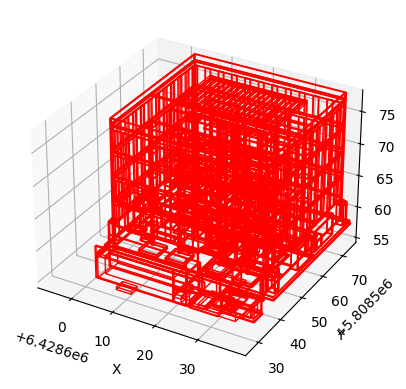

OBJ files have been successfully saved in the directory 'BoundingBox_OBJ_Files', including the combined file.


In [11]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# Function to write an OBJ file for a wireframe bounding box (liner boundary box)
def write_obj_wireframe(filename, vertices, edges):
    with open(filename, 'w') as obj_file:
        # Write the OBJ vertices
        for vertex in vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")
        
        # Write the OBJ edges as lines (polylines)
        obj_file.write("g BoundingBox\n")  # Grouping the box as a whole
        for edge in edges:
            # Note: OBJ file format is 1-based indexing, so we need to add 1 to vertex indices
            obj_file.write(f"l {edge[0] + 1} {edge[1] + 1}\n")

# Function to visualize the combined bounding boxes in a Jupyter notebook
def visualize_combined_bounding_boxes(vertices_list, edges_list):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Draw the boxes by adding lines for edges
    for vertices, edges in zip(vertices_list, edges_list):
        edge_lines = [(vertices[edge[0]], vertices[edge[1]]) for edge in edges]
        ax.add_collection3d(Line3DCollection(edge_lines, colors='r', linewidths=1))

    # Set plot limits dynamically based on all bounding boxes
    all_x = [v[0] for vertices in vertices_list for v in vertices]
    all_y = [v[1] for vertices in vertices_list for v in vertices]
    all_z = [v[2] for vertices in vertices_list for v in vertices]
    
    ax.set_xlim([min(all_x), max(all_x)])
    ax.set_ylim([min(all_y), max(all_y)])
    ax.set_zlim([min(all_z), max(all_z)])

    # Label axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

# Directory to save the OBJ files
output_dir = 'BoundingBox_OBJ_Files'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Input file that contains the extracted information
input_file = 'IFC_info_extraction.txt'

# Prepare lists to store the vertices and edges for the combined OBJ file
combined_vertices = []
combined_edges = []
vertex_offset = 0  # To keep track of vertex indices for multiple boxes

# Read the input file and extract bounding box information
with open(input_file, 'r', encoding='utf-8') as f:
    # Read the header line (ignoring for now)
    header = f.readline().strip()

    # Iterate through the rest of the file
    for line in f:
        # Split the line by tab (assuming tab-separated values)
        columns = line.strip().split('\t')

        # Assuming columns structure is:
        # Task ID, GUID, Task Name, Bounding Box, Scheduled Start Date, Scheduled Finish Date
        guid = columns[1]
        bounding_box_str = columns[3]

        # Parse the bounding box string (assuming format: (min_x, min_y, min_z, max_x, max_y, max_z))
        if bounding_box_str != "No bounding box data":
            bounding_box = eval(bounding_box_str)  # Converts the string "(min_x, min_y, min_z, max_x, max_y, max_z)" to a tuple

            min_x, min_y, min_z, max_x, max_y, max_z = bounding_box

            # Define the 8 vertices of the bounding box
            vertices = [
                [min_x, min_y, min_z],
                [min_x, min_y, max_z],
                [min_x, max_y, min_z],
                [min_x, max_y, max_z],
                [max_x, min_y, min_z],
                [max_x, min_y, max_z],
                [max_x, max_y, min_z],
                [max_x, max_y, max_z],
            ]

            # Define the 12 edges that connect the vertices (for wireframe box)
            edges = [
                [0, 1], [1, 3], [3, 2], [2, 0],  # Bottom face edges
                [4, 5], [5, 7], [7, 6], [6, 4],  # Top face edges
                [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
            ]

            # Write individual OBJ file for each bounding box
            output_filename = f"BoundingBox_{guid}.obj"
            output_path = os.path.join(output_dir, output_filename)
            write_obj_wireframe(output_path, vertices, edges)

            # Add the vertices and edges to the combined list
            combined_vertices.extend(vertices)
            combined_edges.extend([[e[0] + vertex_offset, e[1] + vertex_offset] for e in edges])
            vertex_offset += len(vertices)

# Write the combined OBJ file with all bounding boxes
combined_obj_filename = os.path.join(output_dir, "BoundingBox_Combined.obj")
write_obj_wireframe(combined_obj_filename, combined_vertices, combined_edges)

# Visualize the combined bounding boxes
visualize_combined_bounding_boxes([combined_vertices], [combined_edges])

print(f"OBJ files have been successfully saved in the directory '{output_dir}', including the combined file.")


In [71]:
# all the drone captures date: 

# 1.	2024-05-02
# 2.	2024-05-27
# 3.	2024-06-28
# 4.	2024-07-11
# 5.	2024-07-18
# 6.	2024-08-06
# 7.	2024-08-20
# 8.	2024-09-07
# 9.	2024-10-01
# 10.	2024-11-06


#all the scheduled completion date:
# 1. 16-04-2024
# 2. 29-04-2024
# 3. 23-05-2024
# 4. 06-06-2024
# 5. 25-06-2024
# 6. 28-06-2024
# 7. 01-07-2024
# 8. 08-07-2024
# 9. 19-07-2024
# 10. 23-07-2024
# 11. 26-07-2024
# 12. 30-07-2024
# 13. 12-08-2024
# 14. 16-08-2024
# 15. 19-08-2024
# 16. 20-08-2024
# 17. 26-08-2024
# 18. 28-08-2024
# 19. 30-08-2024
# 20. 12-09-2024
# 21. 23-09-2024


# mapping between drone date and schedule completion date

# 1.	before 2024-05-02:
# 16-04-2024
# 29-04-2024

# 2.	2024-05-02 to 2024-05-27:
# 23-05-2024

# 3.	2024-05-27 to 2024-06-28
# 06-06-2024
# 25-06-2024
# 28-06-2024

# 4.	2024-06-28 to 2024-07-11
# 01-07-2024
# 08-07-2024

# 5.	2024-07-11 to 2024-07-18
# -

# 6.	2024-07-18 - 2024-08-06



# 7.	2024-08-20
# 8.	2024-09-07
# 9.	2024-10-01
# 10.	2024-11-06



In [15]:
# extract all the scheduled completion date

import datetime

# Input file that contains the extracted information
input_file = 'IFC_info_extraction.txt'

# Set to store unique "Scheduled Completion Date" values
scheduled_completion_dates = set()

# Read the input file and extract the "Scheduled Completion Date" values
with open(input_file, 'r', encoding='utf-8') as f:
    # Read the header line (ignoring for now)
    header = f.readline().strip()

    # Iterate through the rest of the file
    for line in f:
        # Split the line by tab (assuming tab-separated values)
        columns = line.strip().split('\t')

        # Assuming the last column is "Scheduled Completion Date"
        scheduled_completion_date = columns[-1]  # Get the last column value

        # Add to the set (set ensures unique values), exclude N/A and invalid dates
        if scheduled_completion_date != "N/A" and scheduled_completion_date:
            scheduled_completion_dates.add(scheduled_completion_date)

# Convert the set to a list of datetime objects and sort the dates
def parse_date(date_str):
    # Assuming the date format is 'DD-MM-YYYY'
    return datetime.datetime.strptime(date_str, '%d-%m-%Y')

# Convert the dates to datetime objects and sort them
scheduled_completion_dates_list = sorted(scheduled_completion_dates, key=parse_date)

# Print the sorted results
print("List of Scheduled Completion Dates (ranked from early to late):")
for date in scheduled_completion_dates_list:
    print(date)



List of Scheduled Completion Dates (ranked from early to late):
16-04-2024
29-04-2024
23-05-2024
06-06-2024
25-06-2024
28-06-2024
01-07-2024
08-07-2024
19-07-2024
23-07-2024
26-07-2024
30-07-2024
12-08-2024
16-08-2024
19-08-2024
20-08-2024
26-08-2024
28-08-2024
30-08-2024
12-09-2024
23-09-2024


# 4.1. Calculate the no. of points in the PCD based on the schedule completed date (1.	2024-05-02)

In [3]:

# calculate the no.of points of each boundary box 

import re

# 读取txt文件并解析边界框数据
def parse_txt(file_path):
    bbox_list = []
    details_list = []
    # Regular expression pattern to extract data from the text file
    pattern = re.compile(r'(\S+)\s+(\S+)\s+([^\t]+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+\S+\s+(\d{2}-\d{2}-\d{4})\s+(\d{2}-\d{2}-\d{4})')
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            for line in lines:
                match = pattern.match(line)
                if match:
                    task_id = match.group(1)
                    guid = match.group(2)
                    task_name = match.group(3)
                    min_x = float(match.group(4))
                    min_y = float(match.group(5))
                    min_z = float(match.group(6))
                    max_x = float(match.group(7))
                    max_y = float(match.group(8))
                    max_z = float(match.group(9))
                    scheduled_start_date = match.group(10)
                    scheduled_finish_date = match.group(11)
                    bbox_list.append(((min_x, min_y, min_z), (max_x, max_y, max_z)))
                    details_list.append((task_id, guid, task_name, scheduled_start_date, scheduled_finish_date))
    except Exception as e:
        print(f"Error reading text file: {e}")
    return bbox_list, details_list

# 读取并解析ply文件中的点数据
def parse_ply(file_path):
    points = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            start = False
            for line in lines:
                if start:
                    parts = line.split()
                    # Check if the line contains at least three elements (x, y, z)
                    if len(parts) < 3:
                        continue
                    x = float(parts[0])
                    y = float(parts[1])
                    z = float(parts[2])
                    points.append((x, y, z))
                if line.strip() == "end_header":
                    start = True
    except Exception as e:
        print(f"Error reading PLY file: {e}")
    return points

# 检查点是否在边界框内
def is_point_in_bbox(point, bbox):
    (min_x, min_y, min_z), (max_x, max_y, max_z) = bbox
    x, y, z = point
    return min_x <= x <= max_x and min_y <= y <= max_y and min_z <= z <= max_z

# 计算每个边界框内的点数
def count_points_in_bboxes(bbox_list, points):
    counts = []
    for bbox in bbox_list:
        count = sum(1 for point in points if is_point_in_bbox(point, bbox))
        counts.append(count)
    return counts

# 主函数
def main():
    txt_file_path = 'scan date IFC boundary/ifc_element_details_2024-05-02.txt'  
    ply_file_path = 'c:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/filtered/Rotated/20240502.ply'  # 替换为你的ply文件路径

    bbox_list, details_list = parse_txt(txt_file_path)
    points = parse_ply(ply_file_path)
    
    if not bbox_list or not points:
        print("Bounding boxes or points could not be loaded.")
        return

    counts = count_points_in_bboxes(bbox_list, points)

    output_file_path = 'no_of_points/points_in_bounding_boxes_2024-05-02.txt'
    try:
        with open(output_file_path, 'w', encoding='utf-8') as output_file:
            for i, count in enumerate(counts):
                bbox = bbox_list[i]
                details = details_list[i]
                output_file.write(f'{i + 1} {count} {bbox[0][0]} {bbox[0][1]} {bbox[0][2]} {bbox[1][0]} {bbox[1][1]} {bbox[1][2]} {details[0]} {details[1]} "{details[2]}" {details[3]} {details[4]}\n')
        print(f"统计完成，结果已保存到 {output_file_path}")
    except Exception as e:
        print(f"Error writing to output file: {e}")

if __name__ == "__main__":
    main()


统计完成，结果已保存到 no_of_points/points_in_bounding_boxes_2024-05-02.txt


# 4.2. Exact the completed GUID (1.	2024-05-02)

In [6]:
import os

def extract_points_and_guid(input_file_path, output_folder_path, scan_date):
    # Ensure the output folder exists
    os.makedirs(output_folder_path, exist_ok=True)
    output_file_path = os.path.join(output_folder_path, "GUID_detecteddate_2024-05-02.txt")

    # Open the input file and the output file
    with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
        for line in infile:
            parts = line.strip().split()
            if len(parts) >= 10:  # Ensure there are enough columns
                points_count = parts[1]  # Second column: number of points
                guid = parts[9]  # Tenth column: GUID
                # Write to the output file
                outfile.write(f"{points_count},{guid},{scan_date}\n")

    # Print the output file path
    print(f"Data has been written to {output_file_path}")

# Define input file path, output folder path, and scan date
input_file_path = "no_of_points/points_in_bounding_boxes_2024-05-02.txt"  # Replace with your actual input file path
output_folder_path = "output"  # Replace with your desired output folder path
scan_date = "2024-05-02"

# Extract the data
extract_points_and_guid(input_file_path, output_folder_path, scan_date)



Data has been written to output\GUID_detecteddate_2024-05-02.txt


# 4.2. Exact the uncompleted GUID (1.	2024-05-02) (optional)

In [14]:
# check the boundary boxes with points less than 200 and GUID of completed elements 


import re
import os

def read_filtered_bounding_boxes_and_parse_guids(file_path, min_points=200, output_folder='completed_elements', output_obj_file='completed_boundary_boxes.obj', scan_date='2024-05-02'):
    os.makedirs(output_folder, exist_ok=True)

    output_obj_file = os.path.join(output_folder, f"completed_boundary_boxes_{scan_date}.obj")
    updated_guid_file = os.path.join(output_folder, f"GUID_undetected_{scan_date}_updated.txt")

    bounding_boxes = []
    guids_to_update = []
    pattern = re.compile(r'(\d+)\s+(\d+)\s+([\d\.\-]+)\s+([\d\.\-]+)\s+([\d\.\-]+)\s+([\d\.\-]+)\s+([\d\.\-]+)\s+([\d\.\-]+)\s+(.*)')

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            match = pattern.match(line)
            if match:
                count = int(match.group(2))
                if count < min_points:
                    # Extract bounding box coordinates
                    xmin, ymin, zmin = float(match.group(3)), float(match.group(4)), float(match.group(5))
                    xmax, ymax, zmax = float(match.group(6)), float(match.group(7)), float(match.group(8))
                    bounding_boxes.append(((xmin, ymin, zmin), (xmax, ymax, zmax)))

                    # Extract GUID
                    guid = match.group(9)
                    guids_to_update.append((guid, count))

    # Write GUIDs and point counts to a new file
    with open(updated_guid_file, 'w', encoding='utf-8') as out_file:
        for guid, point_count in guids_to_update:
            out_file.write(f"{guid},{point_count}\n")

    print(f"GUIDs and point counts have been written to {updated_guid_file}")

    return bounding_boxes

def generate_obj(bounding_boxes, output_obj_file):
    all_vertices = []
    all_edges = []
    vertex_offset = 0

    for bbox in bounding_boxes:
        xmin, ymin, zmin = bbox[0]
        xmax, ymax, zmax = bbox[1]

        # Define vertices of the bounding box
        vertices = [
            (xmin, ymin, zmin),
            (xmax, ymin, zmin),
            (xmin, ymax, zmin),
            (xmax, ymax, zmin),
            (xmin, ymin, zmax),
            (xmax, ymin, zmax),
            (xmin, ymax, zmax),
            (xmax, ymax, zmax),
        ]

        # Define the edges connecting the vertices to form the lines of the bounding box
        edges = [
            (0, 1), (0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (2, 6),
            (3, 7), (4, 5), (4, 6), (5, 7), (6, 7)
        ]

        all_vertices.extend(vertices)
        all_edges.extend([(v1 + vertex_offset, v2 + vertex_offset) for v1, v2 in edges])
        vertex_offset += len(vertices)

    # Write to OBJ file
    with open(output_obj_file, 'w') as obj_file:
        obj_file.write("# OBJ file\n")

        # Write vertices
        for vertex in all_vertices:
            obj_file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

        # Write edges as lines
        for edge in all_edges:
            obj_file.write(f"l {edge[0] + 1} {edge[1] + 1}\n")

    print(f"Saved filtered bounding boxes to {output_obj_file}")

def add_date_to_guid_file(input_file_path, output_file_path, date_to_add):
    # Read the input file, add the new date column, and write to the output file
    with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
        # Iterate over each line in the input file
        for line in infile:
            # Remove any trailing whitespace and add the new date column
            updated_line = f"{line.strip()},{date_to_add}\n"
            # Write the updated line to the output file
            outfile.write(updated_line)

    print(f"Updated GUID file with date added: {output_file_path}")

# 使用示例
input_txt_file_path = 'points_in_bounding_boxes_2024-05-02_rotate_ramp.txt'
output_folder_path = 'undetected_elements'
scan_date = '2024-05-02'
output_obj_file_path = f'undetected_boundary_boxes_{scan_date}.obj'
updated_guid_file_path = os.path.join(output_folder_path, f'GUID_undetected_{scan_date}_updated.txt')

# Read bounding boxes and parse GUIDs with points < 200
filtered_bounding_boxes = read_filtered_bounding_boxes_and_parse_guids(input_txt_file_path, min_points=200, output_folder=output_folder_path, output_obj_file=output_obj_file_path, scan_date=scan_date)

# Generate OBJ file
generate_obj(filtered_bounding_boxes, os.path.join(output_folder_path, output_obj_file_path))

GUIDs and point counts have been written to undetected_elements\GUID_undetected_2024-05-02_updated.txt
Saved filtered bounding boxes to undetected_elements\undetected_boundary_boxes_2024-05-02.obj


# 4.3. Update IFC file (1.	2024-05-02)

In [5]:
# update the status and scan date
# both completed and undetected


import ifcopenshell
import ifcopenshell.util.element

def update_ifc_with_construction_status(ifc_file_path, output_file_path, guid_file_path):
    # Load the IFC file
    ifc_file = ifcopenshell.open(ifc_file_path)

    # Read the GUID data from the text file
    guid_data = {}
    with open(guid_file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 3:
                guid = parts[1].strip()
                points_count = int(parts[0].strip())
                updated_date = parts[2].strip()
                guid_data[guid] = {
                    "points_count": points_count,
                    "updated_date": updated_date
                }

    # Update IFC elements based on the GUID data
    for guid, data in guid_data.items():
        # Find the element by GUID in the IFC file
        element = ifc_file.by_guid(guid)
        if not element:
            print(f"Element with GUID {guid} not found in the IFC file.")
            continue

        # Determine the status based on the number of points
        status = "Completed" if data["points_count"] > 200 else "Undetected"

        # Convert the date format to "02 May 2024"
        try:
            date_parts = data["updated_date"].split('-')
            day = date_parts[0]
            month_number = int(date_parts[1])
            year = date_parts[2]
            # Mapping month numbers to names
            month_names = [
                "January", "February", "March", "April", "May", "June",
                "July", "August", "September", "October", "November", "December"
            ]
            month_name = month_names[month_number - 1]
            formatted_date = f"{day} {month_name} {year}"
        except Exception as e:
            print(f"Error in date formatting for GUID {guid}: {e}")
            continue

        # Update the Pset_ConstructionStatus property set
        # Check if Pset_ConstructionStatus exists, if not, create it
        pset = None
        for rel in element.IsDefinedBy:
            if rel.is_a('IfcRelDefinesByProperties') and rel.RelatingPropertyDefinition.is_a('IfcPropertySet'):
                if rel.RelatingPropertyDefinition.Name == "Pset_ConstructionStatus":
                    pset = rel.RelatingPropertyDefinition
                    break
        
        if not pset:
            # Get the owner history
            owner_history = ifc_file.by_type("IfcOwnerHistory")[0]
            # Create a new property set if it doesn't exist
            pset = ifc_file.createIfcPropertySet(
                ifcopenshell.guid.new(), owner_history, "Pset_ConstructionStatus", None, []
            )
            # Create a relationship between the element and the property set
            ifc_file.createIfcRelDefinesByProperties(
                ifcopenshell.guid.new(), owner_history, None, None, [element], pset
            )
        
        # Update or create the 'Status' property
        status_property = next((prop for prop in pset.HasProperties if prop.Name == "Status"), None)
        if status_property:
            status_property.NominalValue = ifc_file.create_entity("IfcLabel", status)
        else:
            status_property = ifc_file.createIfcPropertySingleValue(
                "Status", "Status", ifc_file.create_entity("IfcLabel", status), None
            )
            pset.HasProperties.append(status_property)

        # Update or create the 'UpdatedDate' property
        updated_date_property = next((prop for prop in pset.HasProperties if prop.Name == "UpdatedDate"), None)
        if updated_date_property:
            updated_date_property.NominalValue = ifc_file.create_entity("IfcLabel", formatted_date)
        else:
            updated_date_property = ifc_file.createIfcPropertySingleValue(
                "UpdatedDate", "UpdatedDate", ifc_file.create_entity("IfcLabel", formatted_date), None
            )
            pset.HasProperties.append(updated_date_property)

    # Save the modified IFC file
    ifc_file.write(output_file_path)
    print(f"Modified IFC file saved at {output_file_path}")

# Paths to the files
ifc_file_path = "C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/RPP-PWY-KON-XX-ZZ-MB-001-10-schedule_construction_status_empty.ifc"
output_file_path = "C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_0502.ifc"
guid_file_path = "output/GUID_detecteddate.txt"  # Replace with the actual path

# Update the IFC file with the construction status
update_ifc_with_construction_status(ifc_file_path, output_file_path, guid_file_path)


Modified IFC file saved at C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_0502.ifc


In [20]:
# export undetected GUID 

import csv

# Define input and output file paths
input_file = r"output/GUID_detecteddate_2024-05-02.txt"    # Update with your actual input file path
output_file = r"undetected_elements/2024-05-02.txt"  # Update with your desired output file path

# Open the input file for reading and the output file for writing
with open(input_file, "r", encoding="utf-8", newline="") as infile, \
     open(output_file, "w", encoding="utf-8", newline="") as outfile:
    
    # Create a CSV reader using comma as the delimiter
    reader = csv.reader(infile, delimiter=",")
    
    for row in reader:
        # Skip empty lines
        if not row:
            continue
        
        # Assume the CSV has at least three columns:
        #   1st column: number of points
        #   2nd column: GUID
        #   3rd column: date
        try:
            # Convert the first column to an integer (number of points)
            points = int(row[0].strip())
        except ValueError:
            # If conversion fails, skip this row
            continue
        
        # If the number of points is less than 200, extract the GUID (2nd column)
        if points < 200:
            guid = row[1].strip()
            outfile.write(guid + "\n")

print(f"GUIDs extracted to {output_file}")


GUIDs extracted to undetected_elements/2024-05-02.txt


In [21]:
# set the undetected element GUID to red

import ifcopenshell

# --- File Paths ---
ifc_file_path = r"C:.../construction_status_0502.ifc"
new_ifc_file_path = r"C:.../construction_status_until_2024-05-02_color.ifc"
guid_txt_file = r"undetected_elements/2024-05-02.txt"  # Change this to the path of your text file containing GUIDs

# --- Read GUIDs from the text file ---
with open(guid_txt_file, "r") as f:
    guid_list = [line.strip() for line in f if line.strip()]

# --- Open the IFC file ---
ifc_file = ifcopenshell.open(ifc_file_path)

# --- Create the Red Color Style ---
# 1. Create an IfcColourRgb entity for red (RGB values are normalized between 0 and 1)
red_colour = ifc_file.create_entity("IfcColourRgb", Name="Red", Red=1.0, Green=0.0, Blue=0.0)

# 2. Create an IfcSurfaceStyleRendering that uses the red colour
surface_style_rendering = ifc_file.create_entity(
    "IfcSurfaceStyleRendering",
    SurfaceColour=red_colour,
    Transparency=0.0  # No transparency
)

# 3. Create an IfcSurfaceStyle that wraps the rendering (applies to both sides)
surface_style = ifc_file.create_entity(
    "IfcSurfaceStyle",
    Name="Red Surface Style",
    Side="BOTH",
    Styles=[surface_style_rendering]
)

# 4. Create an IfcPresentationStyleAssignment to hold the surface style
presentation_style_assignment = ifc_file.create_entity(
    "IfcPresentationStyleAssignment",
    Styles=[surface_style]
)

# --- Process Each GUID from the List ---
for guid in guid_list:
    element = ifc_file.by_guid(guid)
    if element is None:
        print(f"Element with GUID {guid} not found in the IFC file.")
        continue

    if hasattr(element, "Representation") and element.Representation:
        # Loop through each representation of the element
        for rep in element.Representation.Representations:
            # Loop through each geometric item in the representation
            for item in rep.Items:
                # Create an IfcStyledItem to apply the red style to the geometry
                styled_item = ifc_file.create_entity(
                    "IfcStyledItem",
                    Item=item,
                    Styles=[presentation_style_assignment],
                    Name="Red style assignment"
                )
    else:
        print(f"Element with GUID {guid} has no representation. Skipping style assignment.")

# --- Save the Modified IFC File ---
ifc_file.write(new_ifc_file_path)
print(f"New IFC file with red styled elements saved as: {new_ifc_file_path}")


New IFC file with red styled elements saved as: C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-05-02_color.ifc


# 4.1. Calculate the no. of points in the PCD based on the schedule completed date (2.	2024-05-27)

In [3]:

# calculate the no.of points of each boundary box 

import re

# 读取txt文件并解析边界框数据
def parse_txt(file_path):
    bbox_list = []
    details_list = []
    # Regular expression pattern to extract data from the text file
    pattern = re.compile(r'(\S+)\s+(\S+)\s+([^\t]+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)\s+\S+\s+(\d{2}-\d{2}-\d{4})\s+(\d{2}-\d{2}-\d{4})')
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            for line in lines:
                match = pattern.match(line)
                if match:
                    task_id = match.group(1)
                    guid = match.group(2)
                    task_name = match.group(3)
                    min_x = float(match.group(4))
                    min_y = float(match.group(5))
                    min_z = float(match.group(6))
                    max_x = float(match.group(7))
                    max_y = float(match.group(8))
                    max_z = float(match.group(9))
                    scheduled_start_date = match.group(10)
                    scheduled_finish_date = match.group(11)
                    bbox_list.append(((min_x, min_y, min_z), (max_x, max_y, max_z)))
                    details_list.append((task_id, guid, task_name, scheduled_start_date, scheduled_finish_date))
    except Exception as e:
        print(f"Error reading text file: {e}")
    return bbox_list, details_list

# 读取并解析ply文件中的点数据
def parse_ply(file_path):
    points = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            start = False
            for line in lines:
                if start:
                    parts = line.split()
                    # Check if the line contains at least three elements (x, y, z)
                    if len(parts) < 3:
                        continue
                    x = float(parts[0])
                    y = float(parts[1])
                    z = float(parts[2])
                    points.append((x, y, z))
                if line.strip() == "end_header":
                    start = True
    except Exception as e:
        print(f"Error reading PLY file: {e}")
    return points

# 检查点是否在边界框内
def is_point_in_bbox(point, bbox):
    (min_x, min_y, min_z), (max_x, max_y, max_z) = bbox
    x, y, z = point
    return min_x <= x <= max_x and min_y <= y <= max_y and min_z <= z <= max_z

# 计算每个边界框内的点数
def count_points_in_bboxes(bbox_list, points):
    counts = []
    for bbox in bbox_list:
        count = sum(1 for point in points if is_point_in_bbox(point, bbox))
        counts.append(count)
    return counts

# 主函数
def main():
    txt_file_path = 'categorized_IFC_data/old_v2/IFC_info_extraction_between_2024-05-02_and_2024-05-27.txt'  
    ply_file_path = 'c:.../2024-05-27.ply'  # 替换为你的ply文件路径

    bbox_list, details_list = parse_txt(txt_file_path)
    points = parse_ply(ply_file_path)
    
    if not bbox_list or not points:
        print("Bounding boxes or points could not be loaded.")
        return

    counts = count_points_in_bboxes(bbox_list, points)

    output_file_path = 'no_of_points/points_in_bounding_boxes_2024-05-27.txt'
    try:
        with open(output_file_path, 'w', encoding='utf-8') as output_file:
            for i, count in enumerate(counts):
                bbox = bbox_list[i]
                details = details_list[i]
                output_file.write(f'{i + 1} {count} {bbox[0][0]} {bbox[0][1]} {bbox[0][2]} {bbox[1][0]} {bbox[1][1]} {bbox[1][2]} {details[0]} {details[1]} "{details[2]}" {details[3]} {details[4]}\n')
        print(f"统计完成，结果已保存到 {output_file_path}")
    except Exception as e:
        print(f"Error writing to output file: {e}")

if __name__ == "__main__":
    main()


统计完成，结果已保存到 no_of_points/points_in_bounding_boxes_2024-05-27.txt


# 4.2. Exact the No.of point according to GUID (2.	2024-05-27)

In [7]:
import os

def extract_points_and_guid(input_file_path, output_folder_path, scan_date):
    # Ensure the output folder exists
    os.makedirs(output_folder_path, exist_ok=True)
    output_file_path = os.path.join(output_folder_path, "GUID_detecteddate_2024-05-27.txt")

    # Open the input file and the output file
    with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
        for line in infile:
            parts = line.strip().split()
            if len(parts) >= 10:  # Ensure there are enough columns
                points_count = parts[1]  # Second column: number of points
                guid = parts[9]  # Tenth column: GUID
                # Write to the output file
                outfile.write(f"{points_count},{guid},{scan_date}\n")

    # Print the output file path
    print(f"Data has been written to {output_file_path}")

# Define input file path, output folder path, and scan date
input_file_path = "no_of_points/points_in_bounding_boxes_2024-05-27.txt"  # Replace with your actual input file path
output_folder_path = "output"  # Replace with your desired output folder path
scan_date = "2024-05-27"

# Extract the data
extract_points_and_guid(input_file_path, output_folder_path, scan_date)

Data has been written to output\GUID_detecteddate_2024-05-27.txt


# 4.3. Update the status (2. 2024-05-27)

In [9]:
# update the status and scan date
# both completed and undetected


import ifcopenshell
import ifcopenshell.util.element

def update_ifc_with_construction_status(ifc_file_path, output_file_path, guid_file_path):
    # Load the IFC file
    ifc_file = ifcopenshell.open(ifc_file_path)

    # Read the GUID data from the text file
    guid_data = {}
    with open(guid_file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 3:
                guid = parts[1].strip()
                points_count = int(parts[0].strip())
                updated_date = parts[2].strip()
                guid_data[guid] = {
                    "points_count": points_count,
                    "updated_date": updated_date
                }

    # Update IFC elements based on the GUID data
    for guid, data in guid_data.items():
        # Find the element by GUID in the IFC file
        element = ifc_file.by_guid(guid)
        if not element:
            print(f"Element with GUID {guid} not found in the IFC file.")
            continue

        # Determine the status based on the number of points
        status = "Completed" if data["points_count"] > 200 else "Undetected"

        # Convert the date format to "02 May 2024"
        try:
            date_parts = data["updated_date"].split('-')
            day = date_parts[0]
            month_number = int(date_parts[1])
            year = date_parts[2]
            # Mapping month numbers to names
            month_names = [
                "January", "February", "March", "April", "May", "June",
                "July", "August", "September", "October", "November", "December"
            ]
            month_name = month_names[month_number - 1]
            formatted_date = f"{day} {month_name} {year}"
        except Exception as e:
            print(f"Error in date formatting for GUID {guid}: {e}")
            continue

        # Update the Pset_ConstructionStatus property set
        # Check if Pset_ConstructionStatus exists, if not, create it
        pset = None
        for rel in element.IsDefinedBy:
            if rel.is_a('IfcRelDefinesByProperties') and rel.RelatingPropertyDefinition.is_a('IfcPropertySet'):
                if rel.RelatingPropertyDefinition.Name == "Pset_ConstructionStatus":
                    pset = rel.RelatingPropertyDefinition
                    break
        
        if not pset:
            # Get the owner history
            owner_history = ifc_file.by_type("IfcOwnerHistory")[0]
            # Create a new property set if it doesn't exist
            pset = ifc_file.createIfcPropertySet(
                ifcopenshell.guid.new(), owner_history, "Pset_ConstructionStatus", None, []
            )
            # Create a relationship between the element and the property set
            ifc_file.createIfcRelDefinesByProperties(
                ifcopenshell.guid.new(), owner_history, None, None, [element], pset
            )
        
        # Update or create the 'Status' property
        status_property = next((prop for prop in pset.HasProperties if prop.Name == "Status"), None)
        if status_property:
            status_property.NominalValue = ifc_file.create_entity("IfcLabel", status)
        else:
            status_property = ifc_file.createIfcPropertySingleValue(
                "Status", "Status", ifc_file.create_entity("IfcLabel", status), None
            )
            pset.HasProperties.append(status_property)

        # Update or create the 'UpdatedDate' property
        updated_date_property = next((prop for prop in pset.HasProperties if prop.Name == "UpdatedDate"), None)
        if updated_date_property:
            updated_date_property.NominalValue = ifc_file.create_entity("IfcLabel", formatted_date)
        else:
            updated_date_property = ifc_file.createIfcPropertySingleValue(
                "UpdatedDate", "UpdatedDate", ifc_file.create_entity("IfcLabel", formatted_date), None
            )
            pset.HasProperties.append(updated_date_property)

    # Save the modified IFC file
    ifc_file.write(output_file_path)
    print(f"Modified IFC file saved at {output_file_path}")

# Paths to the files
ifc_file_path = "C:.../construction_status_0502.ifc"
output_file_path = "C:.../construction_status_until_2024-05-27.ifc"
guid_file_path = "output/GUID_detecteddate_2024-05-27.txt"  # Replace with the actual path

# Update the IFC file with the construction status
update_ifc_with_construction_status(ifc_file_path, output_file_path, guid_file_path)


Modified IFC file saved at C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-05-27.ifc


# 4.4. Check duplicated items (2. 2024-05-27)

In [10]:
# extract the undetected elements in the '2024-05-27'

import ifcopenshell
import os

# Load the IFC file
ifc_file_path = "C:.../construction_status_until_2024-05-27.ifc"  # Change this to your actual IFC file
ifc_file = ifcopenshell.open(ifc_file_path)

# Output file to store extracted GUIDs
output_file = "undetected_elements/2024-05-27.txt"

# Function to get property value from Pset_ConstructionStatus
def get_property_value(properties, name):
    for prop in properties:
        if prop.Name == name:
            return prop.NominalValue.wrappedValue if hasattr(prop.NominalValue, 'wrappedValue') else prop.NominalValue
    return None

# List to store GUIDs of elements with Status = "Undetected"
undetected_guids = []

# Iterate through all IFC elements
for element in ifc_file.by_type("IfcElement"):
    if element.IsDefinedBy:
        for definition in element.IsDefinedBy:
            if hasattr(definition, 'RelatingPropertyDefinition'):
                property_set = definition.RelatingPropertyDefinition
                if property_set.is_a('IfcPropertySet') and property_set.Name == 'Pset_ConstructionStatus':
                    status = get_property_value(property_set.HasProperties, 'Status')
                    
                    # Check if status is "Undetected"
                    if status == "Undetected":
                        undetected_guids.append(element.GlobalId)

# Save extracted GUIDs to a text file
with open(output_file, 'w', encoding='utf-8') as file:
    file.write("\n".join(undetected_guids))

print(f"✅ Extracted {len(undetected_guids)} elements with Status='Undetected'.")
print(f"📂 GUIDs saved in: {output_file}")


✅ Extracted 172 elements with Status='Undetected'.
📂 GUIDs saved in: undetected_elements/2024-05-27.txt


In [3]:
# useful one - recheck the 'undetected elements' to remove duplicating content

import os
import re
import numpy as np
import plyfile
from datetime import datetime

# Define paths
bounding_box_file = "IFC_info_extraction.txt"  # Update this to your actual file
ply_folder = r"C:.../rotated"
output_file = "output/undetected/undetecteddate_2024-05-27.txt"

# List of scan dates from the PLY filenames (sorted in chronological order)
scan_dates = sorted(
    [file.replace(".ply", "") for file in os.listdir(ply_folder) if file.endswith(".ply")],
    key=lambda x: datetime.strptime(x, "%Y-%m-%d")
)

# Load GUID list from a file
guid_list_file = "undetected_elements/2024-05-27.txt"  # File containing GUIDs to check
with open(guid_list_file, 'r', encoding='utf-8') as f:
    guid_list = set(f.read().splitlines())  # Read GUIDs into a set for fast lookup

print(f"✅ Loaded {len(guid_list)} GUIDs from {guid_list_file}")

# Function to extract bounding boxes for GUIDs
def extract_bounding_boxes(file_path, guid_list):
    bounding_boxes = {}

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        header = lines[0].strip().split("\t")
        guid_index = header.index("GUID")
        bbox_index = header.index("Bounding Box (min_x, min_y, min_z, max_x, max_y, max_z)")

        for line in lines[1:]:  # Skip header
            parts = line.strip().split("\t")
            if len(parts) <= max(guid_index, bbox_index):
                continue

            guid = parts[guid_index]
            if guid in guid_list:
                bbox_values = re.findall(r"[-+]?\d*\.\d+|\d+", parts[bbox_index])
                if len(bbox_values) == 6:
                    bounding_boxes[guid] = np.array(list(map(float, bbox_values)))
                    print(f"🟢 Extracted bounding box for GUID: {guid}")

    print(f"✅ Extracted bounding boxes for {len(bounding_boxes)} GUIDs")
    return bounding_boxes

# Extract bounding boxes for relevant GUIDs
bounding_boxes = extract_bounding_boxes(bounding_box_file, guid_list)

# Function to count points inside a single bounding box
def count_points_in_bbox(ply_file, bbox):
    """
    Counts the number of points inside a given bounding box.

    :param ply_file: Path to the PLY file.
    :param bbox: Bounding box as a NumPy array [min_x, min_y, min_z, max_x, max_y, max_z]
    :return: Number of points inside the bounding box.
    """
    try:
        # Load the PLY file
        ply_data = plyfile.PlyData.read(ply_file)
        vertices = np.array([list(v) for v in ply_data["vertex"].data])

        # Extract bounding box limits
        min_x, min_y, min_z, max_x, max_y, max_z = bbox
        mask = (vertices[:, 0] >= min_x) & (vertices[:, 0] <= max_x) & \
               (vertices[:, 1] >= min_y) & (vertices[:, 1] <= max_y) & \
               (vertices[:, 2] >= min_z) & (vertices[:, 2] <= max_z)

        point_count = np.sum(mask)
        return point_count  # Count the number of points inside the bounding box

    except Exception as e:
        print(f"⚠️ Error reading {ply_file}: {e}")
        return 0  # Return 0 if there's an error

# Process each scan date, loading the PLY file once per scan
results = []
unfound_guids = set(bounding_boxes.keys())  # Track GUIDs that haven't been found yet

for scan_date in scan_dates:
    if not unfound_guids:
        print("✅ All GUIDs detected. Exiting loop.")
        break  # Stop if all GUIDs have been detected

    ply_file_path = os.path.join(ply_folder, f"{scan_date}.ply")

    if os.path.exists(ply_file_path):
        print(f"\n📌 Processing scan date: {scan_date} ({len(unfound_guids)} GUIDs left to check)...")

        # Track GUIDs detected in this scan
        detected_this_scan = set()

        # Iterate over GUIDs that have not been detected yet
        for guid in list(unfound_guids):  # Iterate over a copy to allow removal
            bbox = bounding_boxes.get(guid)

            if bbox is None:
                print(f"⚠️ Warning: GUID {guid} does not have a bounding box.")
                continue  # Skip GUIDs without bounding boxes

            detected_points = count_points_in_bbox(ply_file_path, bbox)  # Pass SINGLE bounding box

            print(f"📊 GUID: {guid} -> {detected_points} points detected")

            if detected_points > 200:
                results.append(f"{detected_points},{guid},{scan_date}")
                detected_this_scan.add(guid)  # Mark GUID for removal

        # Remove all detected GUIDs at once (avoids modifying set during iteration)
        unfound_guids -= detected_this_scan

    print(f"📌 Finished processing {scan_date}. Remaining GUIDs: {len(unfound_guids)}")

# Final check to ensure loop exits
if unfound_guids:
    print(f"\n⚠️ WARNING: {len(unfound_guids)} GUIDs never reached 200 points.")
else:
    print("\n✅ All GUIDs have been detected successfully!")

# Save the results to a TXT file
os.makedirs(os.path.dirname(output_file), exist_ok=True)
with open(output_file, 'w', encoding='utf-8') as f:
    f.write("\n".join(results))

# Notify user of undetected GUIDs
if unfound_guids:
    print(f"\n⚠️ WARNING: {len(unfound_guids)} GUIDs never reached 200 points.")
    with open(output_file.replace(".txt", "_undetected.txt"), 'w', encoding='utf-8') as f:
        f.write("\n".join(unfound_guids))

print(f"\n✅ Processing complete! Results saved in '{output_file}'.")


✅ Loaded 172 GUIDs from undetected_elements/2024-05-27.txt
🟢 Extracted bounding box for GUID: 1sBnHI11D8_upIXRIbJcag
🟢 Extracted bounding box for GUID: 3BEM9RJuL66OQs1powNxii
🟢 Extracted bounding box for GUID: 0Jzpf1y6X2vAB0_ioEDIes
🟢 Extracted bounding box for GUID: 2qgoEze1XFJACLFSQT5SGB
🟢 Extracted bounding box for GUID: 25OEvg7lHBaPgVqkXpTWDY
🟢 Extracted bounding box for GUID: 2TvcS$04jCVuM1EIc6h_xn
🟢 Extracted bounding box for GUID: 1wOWMROuD0hul9V5xPlbQy
🟢 Extracted bounding box for GUID: 3aA1ENNWrD9eHXky3aD2nb
🟢 Extracted bounding box for GUID: 2yWTNnNUTDHuCwRXoo6OAb
🟢 Extracted bounding box for GUID: 3rMYBA0Df0sx$DBae5CASm
🟢 Extracted bounding box for GUID: 29usEbEkb6GA8KIr8tuOUy
🟢 Extracted bounding box for GUID: 1Lh4ubY7b9Vhi7urJLoQuC
🟢 Extracted bounding box for GUID: 3HuZG8Gpf9uxCgRlPeUiSv
🟢 Extracted bounding box for GUID: 1ss1yfghT1_vL8Qm5xxeYE
🟢 Extracted bounding box for GUID: 0tcfrHSmTCZPHyY$A1dh2J
🟢 Extracted bounding box for GUID: 0eslOmxQz0Y8_daGHikyxw
🟢 Extracted b

# 4.5. Second updates on the 2024-05-27 (optional)

In [4]:
# update the status and scan date
# both completed and undetected


import ifcopenshell
import ifcopenshell.util.element

def update_ifc_with_construction_status(ifc_file_path, output_file_path, guid_file_path):
    # Load the IFC file
    ifc_file = ifcopenshell.open(ifc_file_path)

    # Read the GUID data from the text file
    guid_data = {}
    with open(guid_file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) == 3:
                guid = parts[1].strip()
                points_count = int(parts[0].strip())
                updated_date = parts[2].strip()
                guid_data[guid] = {
                    "points_count": points_count,
                    "updated_date": updated_date
                }

    # Update IFC elements based on the GUID data
    for guid, data in guid_data.items():
        # Find the element by GUID in the IFC file
        element = ifc_file.by_guid(guid)
        if not element:
            print(f"Element with GUID {guid} not found in the IFC file.")
            continue

        # Determine the status based on the number of points
        status = "Completed" if data["points_count"] > 200 else "Undetected"

        # Convert the date format to "02 May 2024"
        try:
            date_parts = data["updated_date"].split('-')
            day = date_parts[0]
            month_number = int(date_parts[1])
            year = date_parts[2]
            # Mapping month numbers to names
            month_names = [
                "January", "February", "March", "April", "May", "June",
                "July", "August", "September", "October", "November", "December"
            ]
            month_name = month_names[month_number - 1]
            formatted_date = f"{day} {month_name} {year}"
        except Exception as e:
            print(f"Error in date formatting for GUID {guid}: {e}")
            continue

        # Update the Pset_ConstructionStatus property set
        # Check if Pset_ConstructionStatus exists, if not, create it
        pset = None
        for rel in element.IsDefinedBy:
            if rel.is_a('IfcRelDefinesByProperties') and rel.RelatingPropertyDefinition.is_a('IfcPropertySet'):
                if rel.RelatingPropertyDefinition.Name == "Pset_ConstructionStatus":
                    pset = rel.RelatingPropertyDefinition
                    break
        
        if not pset:
            # Get the owner history
            owner_history = ifc_file.by_type("IfcOwnerHistory")[0]
            # Create a new property set if it doesn't exist
            pset = ifc_file.createIfcPropertySet(
                ifcopenshell.guid.new(), owner_history, "Pset_ConstructionStatus", None, []
            )
            # Create a relationship between the element and the property set
            ifc_file.createIfcRelDefinesByProperties(
                ifcopenshell.guid.new(), owner_history, None, None, [element], pset
            )
        
        # Update or create the 'Status' property
        status_property = next((prop for prop in pset.HasProperties if prop.Name == "Status"), None)
        if status_property:
            status_property.NominalValue = ifc_file.create_entity("IfcLabel", status)
        else:
            status_property = ifc_file.createIfcPropertySingleValue(
                "Status", "Status", ifc_file.create_entity("IfcLabel", status), None
            )
            pset.HasProperties.append(status_property)

        # Update or create the 'UpdatedDate' property
        updated_date_property = next((prop for prop in pset.HasProperties if prop.Name == "UpdatedDate"), None)
        if updated_date_property:
            updated_date_property.NominalValue = ifc_file.create_entity("IfcLabel", formatted_date)
        else:
            updated_date_property = ifc_file.createIfcPropertySingleValue(
                "UpdatedDate", "UpdatedDate", ifc_file.create_entity("IfcLabel", formatted_date), None
            )
            pset.HasProperties.append(updated_date_property)

    # Save the modified IFC file
    ifc_file.write(output_file_path)
    print(f"Modified IFC file saved at {output_file_path}")

# Paths to the files
ifc_file_path = "C:.../construction_status_until_2024-05-27.ifc"
output_file_path = "C:.../construction_status_until_2024-05-27_v1.ifc"
guid_file_path = "output/undetected/undetecteddate_2024-05-27.txt"  # Replace with the actual path

# Update the IFC file with the construction status
update_ifc_with_construction_status(ifc_file_path, output_file_path, guid_file_path)


Modified IFC file saved at C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-05-27_v1.ifc


# 4.6. Secondary extraction (2024-05-27) (optional)

In [8]:
# secondery extraction of '2024-05-27'


import ifcopenshell
import os

# Load the IFC file
ifc_file_path = "C:.../construction_status_until_2024-05-27_v1.ifc"  # Change this to your actual IFC file
ifc_file = ifcopenshell.open(ifc_file_path)

# Output file to store extracted GUIDs
output_file = "undetected_elements/2024-05-27_v1.txt"

# Function to get property value from Pset_ConstructionStatus
def get_property_value(properties, name):
    for prop in properties:
        if prop.Name == name:
            return prop.NominalValue.wrappedValue if hasattr(prop.NominalValue, 'wrappedValue') else prop.NominalValue
    return None

# List to store GUIDs of elements with Status = "Undetected"
undetected_guids = []

# Iterate through all IFC elements
for element in ifc_file.by_type("IfcElement"):
    if element.IsDefinedBy:
        for definition in element.IsDefinedBy:
            if hasattr(definition, 'RelatingPropertyDefinition'):
                property_set = definition.RelatingPropertyDefinition
                if property_set.is_a('IfcPropertySet') and property_set.Name == 'Pset_ConstructionStatus':
                    status = get_property_value(property_set.HasProperties, 'Status')
                    
                    # Check if status is "Undetected"
                    if status == "Undetected":
                        undetected_guids.append(element.GlobalId)

# Save extracted GUIDs to a text file
with open(output_file, 'w', encoding='utf-8') as file:
    file.write("\n".join(undetected_guids))

print(f"✅ Extracted {len(undetected_guids)} elements with Status='Undetected'.")
print(f"📂 GUIDs saved in: {output_file}")

✅ Extracted 124 elements with Status='Undetected'.
📂 GUIDs saved in: undetected_elements/2024-05-27_v1.txt


# 4.7. Set the undetected element GUID to red (2024-05-27) (tested)

In [9]:
# set the undetected element GUID to red

import ifcopenshell

# --- File Paths ---
ifc_file_path = r"C:.../construction_status_until_2024-05-27_v1.ifc"
new_ifc_file_path = r"C:.../construction_status_until_2024-05-27_v1_color.ifc"
guid_txt_file = r"undetected_elements/2024-05-27_v1.txt"  # Change this to the path of your text file containing GUIDs

# --- Read GUIDs from the text file ---
with open(guid_txt_file, "r") as f:
    guid_list = [line.strip() for line in f if line.strip()]

# --- Open the IFC file ---
ifc_file = ifcopenshell.open(ifc_file_path)

# --- Create the Red Color Style ---
# 1. Create an IfcColourRgb entity for red (RGB values are normalized between 0 and 1)
red_colour = ifc_file.create_entity("IfcColourRgb", Name="Red", Red=1.0, Green=0.0, Blue=0.0)

# 2. Create an IfcSurfaceStyleRendering that uses the red colour
surface_style_rendering = ifc_file.create_entity(
    "IfcSurfaceStyleRendering",
    SurfaceColour=red_colour,
    Transparency=0.0  # No transparency
)

# 3. Create an IfcSurfaceStyle that wraps the rendering (applies to both sides)
surface_style = ifc_file.create_entity(
    "IfcSurfaceStyle",
    Name="Red Surface Style",
    Side="BOTH",
    Styles=[surface_style_rendering]
)

# 4. Create an IfcPresentationStyleAssignment to hold the surface style
presentation_style_assignment = ifc_file.create_entity(
    "IfcPresentationStyleAssignment",
    Styles=[surface_style]
)

# --- Process Each GUID from the List ---
for guid in guid_list:
    element = ifc_file.by_guid(guid)
    if element is None:
        print(f"Element with GUID {guid} not found in the IFC file.")
        continue

    if hasattr(element, "Representation") and element.Representation:
        # Loop through each representation of the element
        for rep in element.Representation.Representations:
            # Loop through each geometric item in the representation
            for item in rep.Items:
                # Create an IfcStyledItem to apply the red style to the geometry
                styled_item = ifc_file.create_entity(
                    "IfcStyledItem",
                    Item=item,
                    Styles=[presentation_style_assignment],
                    Name="Red style assignment"
                )
    else:
        print(f"Element with GUID {guid} has no representation. Skipping style assignment.")

# --- Save the Modified IFC File ---
ifc_file.write(new_ifc_file_path)
print(f"New IFC file with red styled elements saved as: {new_ifc_file_path}")


New IFC file with red styled elements saved as: C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-05-27_v1_color.ifc


In [15]:
# update the color

import ifcopenshell
import ifcopenshell.guid

# --- File Paths ---
ifc_file_path = r"C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-06-28_final.ifc"
new_ifc_file_path = r"C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-06-28_color_final.ifc"
guid_txt_file = r"undetected_elements/till-2024-06-28.txt"
output_guid_file = r"red_styled_guids_2024-06-28.txt"

# --- Read GUIDs ---
with open(guid_txt_file, "r") as f:
    guid_list = [L.strip() for L in f if L.strip()]

# --- Open IFC + grab OwnerHistory ---
ifc = ifcopenshell.open(ifc_file_path)
owner = ifc.by_type("IfcOwnerHistory")[0]

# --- 1) Create Red Color ---
red_rgb = ifc.create_entity(
    "IfcColourRgb",
    Name="Red",
    Red=1.0, Green=0.0, Blue=0.0
)

# --- 2) Create Surface Style Rendering ---
rendering = ifc.create_entity(
    "IfcSurfaceStyleRendering",
    SurfaceColour=red_rgb,
    DiffuseColour=red_rgb,
    Transparency=0.0
)

# --- 3) Create Surface Style ---
style = ifc.create_entity(
    "IfcSurfaceStyle",
    Name="RedSurfaceStyle",
    Side="BOTH",
    Styles=[rendering]
)

# --- 4) Loop through GUIDs and apply red style ---
styled_guids = set()
for guid in guid_list:
    try:
        elem = ifc.by_guid(guid)
        if not elem:
            continue

        # Skip if no geometry
        rep_root = getattr(elem, "Representation", None)
        if not rep_root or not rep_root.Representations:
            continue

        styled = False
        for rep in rep_root.Representations:
            if rep.is_a("IfcShapeRepresentation"):
                for geom in rep.Items:
                    # Skip IfcMappedItem to avoid styling shared geometry
                    if geom.is_a("IfcMappedItem"):
                        continue

                    # Check for existing IfcStyledItem
                    existing_styled_items = [
                        styled_item for styled_item in ifc.get_inverse(geom)
                        if styled_item.is_a("IfcStyledItem")
                    ]
                    for styled_item in existing_styled_items:
                        ifc.remove(styled_item)

                    # Create new IfcStyledItem
                    ifc.create_entity(
                        "IfcStyledItem",
                        Item=geom,
                        Styles=[style],
                        Name="RedStyle"
                    )
                    styled = True

        if styled:
            styled_guids.add(guid)

    except Exception:
        continue

# --- 5) Write output IFC file ---
ifc.write(new_ifc_file_path)
print(f"Updated IFC file written to: {new_ifc_file_path}")

# --- 6) Output styled GUIDs ---
if styled_guids:
    print("\nGUIDs of elements styled red:")
    for guid in sorted(styled_guids):
        print(guid)
    with open(output_guid_file, "w") as f:
        for guid in sorted(styled_guids):
            f.write(guid + "\n")
    print(f"\nGUIDs saved to: {output_guid_file}")
else:
    print("\nNo elements were styled red")
print(f"Total elements styled red: {len(styled_guids)}")

Updated IFC file written to: C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-06-28_color_final.ifc

GUIDs of elements styled red:
00J9jwbsb0RBZp8IK6rz7u
01ZKWdkofAKeVazsmuubFe
01eEesW1bEaBvVtxwVil0d
0AQvKBF1b2vwxuCQSi1vJm
0CIn9hZ9r7HAaWMkq0d3Cv
0DD2BuDlnC5hpNG5SEl8LF
0DSlaJ6OHCV85VBFJSTRN9
0Jzpf1y6X2vAB0_ioEDIes
0L6OcMHkn8Uh0ksO_1fSiT
0MQG6Avir8h9GCkAvcPPq_
0OoUCl8y5FX88_0P_gI2Js
0RwtHhi_r5Ww$o_02BUWJi
0Seibpw_L8POxo4qO2EFXR
0Typy0qEb9cgIfkcr6sGD5
0UX9HgccD4sf6ISIO21Hfc
0_HAirpLb4c9y0I4$krhT6
0a6NRyzcT8MAoFppfWhErU
0b1zSK_rfFVPM_2hrTU6jW
0eVBNutBHFwOoFv4Sj33v6
0eslOmxQz0Y8_daGHikyxw
0fzo4qjgjBlRq4MX3G1Aku
0imi_PC7j4MAuEJxHzoRDP
0kJs457NXCse7uXnK__ngJ
0kbi$xy0r1l8mV7taaXVCF
0l0uTdW1r8PPbzBynIARp2
0pdX5UvXH8ju4OrcDEq02R
0rS1ttjUP0gOdCdFzxrcAa
0tcfrHSmTCZPHyY$A1dh2J
0tfUey2MP4GOZDsmcWfC1V
0zFjYfEsn4Y8y1Nym6grqU
1$9en2Fmv2G9r50fOf6KcM
104lOI$Bb9kRnJaTxGLtPR
11rbsWKSHCxR_tyOkC$gYB
12ne$6

In [6]:
# archived code
# some elements are with shared attribute, so changing one cause changing the other, so keep the orginal output.
import ifcopenshell
import ifcopenshell.guid

# --- File Paths ---
input_ifc_file_path = r"C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-06-28_color.ifc"
output_ifc_file_path = r"C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-06-28_corrected.ifc"
wrong_guid_file = r"C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/wrong_2024-06-28.txt"
removed_guid_file = r"C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/removed_red_guids.txt"

try:
    # --- Read GUIDs from wrong_2024-06-28.txt ---
    print(f"Reading GUIDs from: {wrong_guid_file}")
    with open(wrong_guid_file, "r") as f:
        wrong_guids = set(L.strip() for L in f if L.strip())
    print(f"Found {len(wrong_guids)} GUIDs in wrong_2024-06-28.txt")

    # --- Open IFC ---
    print(f"Opening IFC file: {input_ifc_file_path}")
    ifc = ifcopenshell.open(input_ifc_file_path)
    print("IFC file loaded successfully")

    # --- Find Red Surface Style ---
    red_style = None
    for style in ifc.by_type("IfcSurfaceStyle"):
        if style.Name == "RedSurfaceStyle":
            red_style = style
            break

    if not red_style:
        print(" ✗ No IfcSurfaceStyle with Name='RedSurfaceStyle' found")
        exit()

    print("Found RedSurfaceStyle, processing elements...")

    # --- Track GUIDs with removed styles ---
    removed_guids = set()

    # --- Process elements with GUIDs in wrong_guids ---
    for guid in wrong_guids:
        try:
            elem = ifc.by_guid(guid)
            if not elem:
                print(f" ✗ GUID not found in IFC: {guid}")
                continue

            # Check if element has geometry
            rep_root = getattr(elem, "Representation", None)
            if not rep_root or not rep_root.Representations:
                print(f" ✗ No representation for GUID: {guid}")
                continue

            styled_items_removed = False
            for rep in rep_root.Representations:
                if rep.is_a("IfcShapeRepresentation"):
                    for geom in rep.Items:
                        # Find IfcStyledItem linked to RedSurfaceStyle
                        styled_items = [
                            si for si in ifc.get_inverse(geom)
                            if si.is_a("IfcStyledItem") and red_style in si.Styles
                        ]
                        for styled_item in styled_items:
                            print(f"Removing red style for GUID: {guid}, StyledItem #{styled_item.id()}")
                            ifc.remove(styled_item)
                            styled_items_removed = True

            if styled_items_removed:
                removed_guids.add(guid)

        except Exception as e:
            print(f" ✗ Error processing GUID {guid}: {str(e)}")
            continue

    # --- Save removed GUIDs to file ---
    if removed_guids:
        print("\nGUIDs of elements with red style removed:")
        for guid in sorted(removed_guids):
            print(guid)
        with open(removed_guid_file, "w") as f:
            for guid in sorted(removed_guids):
                f.write(guid + "\n")
        print(f"\nGUIDs saved to: {removed_guid_file}")
    else:
        print("\nNo red styles were removed")

    # --- Write output IFC file ---
    ifc.write(output_ifc_file_path)
    print(f"\nUpdated IFC file written to: {output_ifc_file_path}")

    # --- Summary ---
    print(f"Total elements with red style removed: {len(removed_guids)}")

except Exception as e:
    print(f" ✗ Error: {str(e)}")

Reading GUIDs from: C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/wrong_2024-06-28.txt
Found 4 GUIDs in wrong_2024-06-28.txt
Opening IFC file: C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-06-28_color.ifc
IFC file loaded successfully
Found RedSurfaceStyle, processing elements...
Removing red style for GUID: 2CH0KQ0c98y8mxZ7wpzCf5, StyledItem #82166
Removing red style for GUID: 0xxf6Zh2fBEe6siE1TjhoO, StyledItem #82020
Removing red style for GUID: 0S_xGGgBn4QQZg$2mbk$5E, StyledItem #82164
 ✗ Error processing GUID 3HXPfz0g9EBggiR7zk_u$o: Instance with GlobalId '3HXPfz0g9EBggiR7zk_u$o' not found

GUIDs of elements with red style removed:
0S_xGGgBn4QQZg$2mbk$5E
0xxf6Zh2fBEe6siE1TjhoO
2CH0KQ0c98y8mxZ7wpzCf5

GUIDs saved to: C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2

# 4.1. Calculate the no. of points in the PCD based on the schedule completed date (4. 2024-07-11)

# 4.2. Exact the completed GUID (4.	2024-07-11)

# 4.3. Update the status (4. 2024-07-11)

# 4.1. Calculate the no. of points in the PCD based on the schedule completed date (5. 2024-07-18)

# 4.2. Exact the completed GUID (5. 2024-07-18)

# 4.3. Update the status (5. 2024-07-18)

# 4.3. Extract the undetected elements (5. 2024-07-18)

# 4.1. Calculate the no. of points in the PCD based on the schedule completed date (6. 2024-08-06)

# 4.2. Exact the point and detectdate (6.	2024-08-06)

# 4.3. Update the status (6. 2024-08-06)

# 4.1. Calculate the no. of points in the PCD based on the schedule completed date (7. 2024-08-20)

# 4.2. Exact the point and detectdate (7.	2024-08-20)

# 4.3. Update the status (7. 2024-08-20)

# 4.1. Calculate the no. of points in the PCD based on the schedule completed date (8. 2024-09-07)

# 4.2. Exact the point and detectdate (8.	2024-09-07)

# 4.3. Update the status (8. 2024-09-07)

# 4.1. Calculate the no. of points in the PCD based on the schedule completed date (9. 2024-10-01)

# 4.2. Exact the point and detectdate (9.	2024-10-01)

# 4.3. Update the status (9. 2024-10-01)

# 4.1. Calculate the no. of points in the PCD based on the schedule completed date (10. 2024-11-06)

# 5. Extract all undetected elements

In [36]:
import os
import re

# === Configuration ===
output_directory = "C:.../output" # 之前报告文件所在的目录
report_filename = "undetected_elements_report.txt" # 之前生成的报告文件名
guid_list_filename = "undetected_guids.txt" # 新的GUID列表文件名

report_file_path = os.path.join(output_directory, report_filename)
guid_list_file_path = os.path.join(output_directory, guid_list_filename)

# === Function to retrieve GUIDs from the report file ===
def get_guids_from_report(file_path):
    guids = set() # 使用集合来存储唯一的GUIDs
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                # 使用正则表达式匹配以 "GUID: " 开头的行，并提取后面的内容
                match = re.match(r"GUID: (.+)", line.strip())
                if match:
                    guids.add(match.group(1))
        print(f"✅ 成功从 {file_path} 提取到 {len(guids)} 个 GUID。")
    except FileNotFoundError:
        print(f"❌ 错误：报告文件未找到，路径为 {file_path}。请确保先运行生成报告的脚本。")
    except Exception as e:
        print(f"❌ 读取报告文件时出错：{e}")
    return sorted(list(guids)) # 转换为列表并排序，方便查看

# === 提取 GUID ===
extracted_guids = get_guids_from_report(report_file_path)

if not extracted_guids:
    print("报告文件中未找到任何 GUID。")
else:
    # === 将 GUID 写入新的文本文件 ===
    try:
        with open(guid_list_file_path, 'w', encoding='utf-8') as f:
            for guid in extracted_guids:
                f.write(guid + "\n")
        print(f"✅ 所有 GUID 已成功写入到文件: {guid_list_file_path}")
    except Exception as e:
        print(f"❌ 写入 GUID 列表文件时出错：{e}")

✅ 成功从 C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/output\undetected_elements_report.txt 提取到 394 个 GUID。
✅ 所有 GUID 已成功写入到文件: C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/output\undetected_guids.txt


In [37]:
# set the undetected element GUID to red

import ifcopenshell

# --- File Paths ---
ifc_file_path = r"C:.../construction_status_until_2024-10-01_final.ifc"
new_ifc_file_path = r"C:.../construction_status_until_2024-10-01_final.ifc_color.ifc"
guid_txt_file = r"C:.../undetected_guids.txt"  # Change this to the path of your text file containing GUIDs

# --- Read GUIDs from the text file ---
with open(guid_txt_file, "r") as f:
    guid_list = [line.strip() for line in f if line.strip()]

# --- Open the IFC file ---
ifc_file = ifcopenshell.open(ifc_file_path)

# --- Create the Red Color Style ---
# 1. Create an IfcColourRgb entity for red (RGB values are normalized between 0 and 1)
red_colour = ifc_file.create_entity("IfcColourRgb", Name="Red", Red=1.0, Green=0.0, Blue=0.0)

# 2. Create an IfcSurfaceStyleRendering that uses the red colour
surface_style_rendering = ifc_file.create_entity(
    "IfcSurfaceStyleRendering",
    SurfaceColour=red_colour,
    Transparency=0.0  # No transparency
)

# 3. Create an IfcSurfaceStyle that wraps the rendering (applies to both sides)
surface_style = ifc_file.create_entity(
    "IfcSurfaceStyle",
    Name="Red Surface Style",
    Side="BOTH",
    Styles=[surface_style_rendering]
)

# 4. Create an IfcPresentationStyleAssignment to hold the surface style
presentation_style_assignment = ifc_file.create_entity(
    "IfcPresentationStyleAssignment",
    Styles=[surface_style]
)

# --- Process Each GUID from the List ---
for guid in guid_list:
    element = ifc_file.by_guid(guid)
    if element is None:
        print(f"Element with GUID {guid} not found in the IFC file.")
        continue

    if hasattr(element, "Representation") and element.Representation:
        # Loop through each representation of the element
        for rep in element.Representation.Representations:
            # Loop through each geometric item in the representation
            for item in rep.Items:
                # Create an IfcStyledItem to apply the red style to the geometry
                styled_item = ifc_file.create_entity(
                    "IfcStyledItem",
                    Item=item,
                    Styles=[presentation_style_assignment],
                    Name="Red style assignment"
                )
    else:
        print(f"Element with GUID {guid} has no representation. Skipping style assignment.")

# --- Save the Modified IFC File ---
ifc_file.write(new_ifc_file_path)
print(f"New IFC file with red styled elements saved as: {new_ifc_file_path}")


New IFC file with red styled elements saved as: C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-10-01_final.ifc_color.ifc


In [69]:
import ifcopenshell

# --- File Paths ---
ifc_file_path = r"C:.../construction_status_until_2024-10-01_final.ifc"
new_ifc_file_path = r"C:.../construction_status_until_2024-10-01_final.ifc_color.ifc"
guid_txt_file = r"C:.../undetected_guids.txt"

# --- Read GUIDs from the text file ---
with open(guid_txt_file, "r") as f:
    guid_list = [line.strip() for line in f if line.strip()]

# --- Open the IFC file ---
ifc_file = ifcopenshell.open(ifc_file_path)

# --- Create the Red Color Style ---
# 1. Create an IfcColourRgb entity for red (RGB values normalized between 0 and 1)
red_colour = ifc_file.create_entity("IfcColourRgb", Name="Red", Red=1.0, Green=0.0, Blue=0.0)

# 2. Create an IfcSurfaceStyleRendering that uses the red colour
surface_style_rendering = ifc_file.create_entity(
    "IfcSurfaceStyleRendering",
    SurfaceColour=red_colour,
    Transparency=0.0  # No transparency
)

# 3. Create an IfcSurfaceStyle that wraps the rendering
surface_style = ifc_file.create_entity(
    "IfcSurfaceStyle",
    Name="Red Surface Style",
    Side="BOTH",
    Styles=[surface_style_rendering]
)

# 4. Create an IfcPresentationStyleAssignment to hold the surface style
presentation_style_assignment = ifc_file.create_entity(
    "IfcPresentationStyleAssignment",
    Styles=[surface_style]
)

# --- Process Each GUID from the List ---
for guid in guid_list:
    element = ifc_file.by_guid(guid)
    if element is None:
        print(f"Element with GUID {guid} not found in the IFC file.")
        continue

    if not hasattr(element, "Representation") or not element.Representation:
        print(f"Element with GUID {guid} has no representation. Skipping style assignment.")
        continue

    # Get the representation context (assuming the first context is used)
    context = ifc_file.by_type("IfcGeometricRepresentationContext")[0]

    # Process each geometric item in the element's shape representations
    for rep in element.Representation.Representations:
        if rep.is_a("IfcShapeRepresentation"):
            for item in rep.Items:
                # Check if the item already has a styled item
                existing_styled_item = None
                for styled_item in ifc_file.by_type("IfcStyledItem"):
                    if styled_item.Item == item:
                        existing_styled_item = styled_item
                        break

                if existing_styled_item:
                    # Update existing styled item to use the red style
                    existing_styled_item.Styles = [presentation_style_assignment]
                else:
                    # Create a new styled item for the geometry
                    styled_item = ifc_file.create_entity(
                        "IfcStyledItem",
                        Item=item,
                        Styles=[presentation_style_assignment],
                        Name="Red style"
                    )

# --- Save the Modified IFC File ---
ifc_file.write(new_ifc_file_path)
print(f"New IFC file with red styled elements saved as: {new_ifc_file_path}")

New IFC file with red styled elements saved as: C:/Users/yw710/OneDrive - University of Cambridge/BuildSPACE/Pilot Data/Pilot 1_MOS/S1.2 Data_20240618/status_updated_ifc/construction_status_until_2024-10-01_final.ifc_color.ifc
